# Pytorch pretrained model
---
by Pranpaveen Lay.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Download pretrained
https://pytorch.org/vision/stable/models.html

In [4]:
pretrain = torchvision.models.resnext50_32x4d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to C:\Users\Chaos/.cache\torch\hub\checkpoints\resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [5]:
pretrain

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

## imagenet class map

In [6]:
#!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
import ast

In [15]:
with open('imagenet1000_clsidx_to_labels.txt','r') as file:
    data = file.read()
    img_dict = ast.literal_eval(data)

In [16]:
img_dict

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [17]:
from PIL import Image
from urllib.request import urlopen
import io

In [18]:
img_url = 'https://s.isanook.com/wo/0/rp/r/w728/ya0xa0m1w0/aHR0cHM6Ly9zLmlzYW5vb2suY29tL3dvLzAvdWQvMzMvMTY3MDc1L2MuanBn.jpg'
fd = urlopen(img_url)
image_file = io.BytesIO(fd.read())
img = Image.open(image_file)

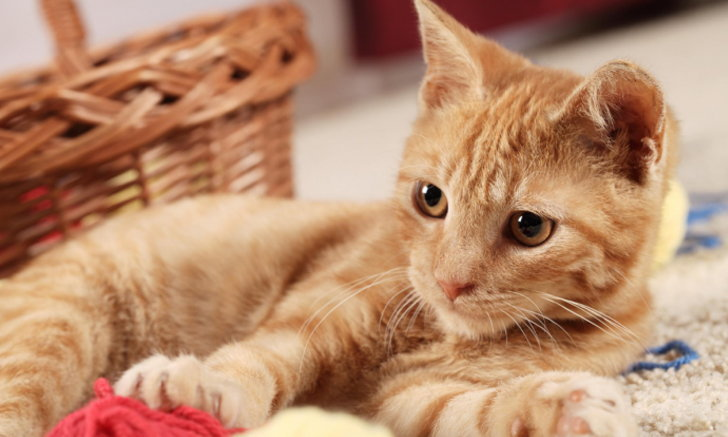

In [19]:
img

In [50]:
transform = transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.ToTensor()
])

In [51]:
img_tensor = transform(img)
img_tensor.shape

torch.Size([3, 256, 256])

In [52]:
img_tensor = torch.unsqueeze(img_tensor,0)
img_tensor.shape

torch.Size([1, 3, 256, 256])

In [53]:
def model_predict(model,image,top=5):
    model.eval()
    image = image.to(device)
    if image.ndim ==3:
        image = torch.unsqueeze(image,0)
    with torch.no_grad():
        pred = model(image)
        pred = F.softmax(pred)
    pred_arg = torch.argsort(pred,descending=True)
    pred_arg = pred_arg[0,:top].cpu().detach().numpy()
    pred = pred[0].cpu().detach().numpy()
    output = list()
    for sub_pred in pred_arg:
        output.append({'class':sub_pred,'class_name':img_dict[sub_pred],'prob':pred[sub_pred]})
    return output

In [54]:
pretrain = pretrain.to(device)

In [55]:
predict = model_predict(pretrain,img_tensor)

<ipython-input-53-a19c7b667349>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(pred)


In [56]:
predict

[{'class': 285, 'class_name': 'Egyptian cat', 'prob': 0.18858446},
 {'class': 700, 'class_name': 'paper towel', 'prob': 0.14801756},
 {'class': 588, 'class_name': 'hamper', 'prob': 0.14436248},
 {'class': 282, 'class_name': 'tiger cat', 'prob': 0.102193736},
 {'class': 478, 'class_name': 'carton', 'prob': 0.06825395}]

# Fine tune pretrained

In [58]:
import pandas as pd
import os,glob

## Data

In [59]:
data_path = 'data/cat-dog/train/' #/cat /dog
os.listdir(data_path)

['cat', 'dog']

In [60]:
data_cat = glob.glob("data/cat-dog/train/cat/*")
data_dog = glob.glob("data/cat-dog/train/dog/*")

In [103]:
df_cat = pd.DataFrame({'data_path':data_cat, 'label':['cat']*len(data_cat)})
df_dog = pd.DataFrame({'data_path':data_dog, 'label':['dog']*len(data_dog)})
df = pd.concat([df_cat,df_dog])

In [104]:
df

,data_path,label
0,data/cat-dog/train/cat\0.jpg,cat
1,data/cat-dog/train/cat\1.jpg,cat
2,data/cat-dog/train/cat\10.jpg,cat
3,data/cat-dog/train/cat\100.jpg,cat
4,data/cat-dog/train/cat\1000.jpg,cat
...,...,...
996,data/cat-dog/train/dog\995.jpg,dog
997,data/cat-dog/train/dog\996.jpg,dog
998,data/cat-dog/train/dog\997.jpg,dog
999,data/cat-dog/train/dog\998.jpg,dog


In [105]:
class_dict = {'cat':0,'dog':1}
df['label_num'] = df['label'].map(class_dict)

In [106]:
df = df.sample(frac=1).reset_index(drop=True)
df

,data_path,label,label_num
0,data/cat-dog/train/cat\299.jpg,cat,0
1,data/cat-dog/train/dog\240.jpg,dog,1
2,data/cat-dog/train/dog\327.jpg,dog,1
3,data/cat-dog/train/cat\171.jpg,cat,0
4,data/cat-dog/train/dog\200.jpg,dog,1
...,...,...,...
1997,data/cat-dog/train/cat\288.jpg,cat,0
1998,data/cat-dog/train/cat\782.jpg,cat,0
1999,data/cat-dog/train/cat\565.jpg,cat,0
2000,data/cat-dog/train/cat\88.jpg,cat,0


In [107]:
df_train = df[:1600]
df_val = df[1600:]

## Data transform / augment
---
https://pytorch.org/vision/master/transforms.html  
https://pytorch.org/vision/master/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-  

In [108]:
class imageTransform():
    def __init__(self):
        self.transform = {
            'train': transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.RandomRotation(degrees=(-30, 30)),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
            ]),
            'test': transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
            ])
        }

    def __call__(self, img, phase):
        return self.transform[phase](img)

In [254]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=imageTransform(), phase='train'):
        self.df = df
        self.img_path = df['data_path'].values
        self.label = df['label_num'].values
        self.transform = transform
        self.phase = phase
        
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self,idx):
        img_path = self.img_path[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img, self.phase)
        label = self.label[idx]
        return img_transformed, label
    

In [255]:
train_dataset = ImageDataset(df_train,phase='train')
val_dataset = ImageDataset(df_val,phase='val')

In [256]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32,shuffle=False, num_workers=0, pin_memory=True)

In [257]:
pretrain.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): GELU()
  (2): Linear(in_features=256, out_features=2, bias=True)
)

In [258]:
pretrain.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        

## Model

In [279]:
class resnextFinetune(nn.Module):
    def __init__(self,out_feature=2):
        super().__init__()
        self.model = torchvision.models.resnext50_32x4d(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Sequential(
                            nn.Linear(2048,256),
                            nn.ReLU(),
                            nn.Linear(256,out_feature),
                            nn.LogSoftmax()
                        )
    def forward(self,x):
        x = self.model(x)
        return x

In [280]:
model = resnextFinetune().to(device)

In [281]:
# for name,param in model.named_parameters():
#     if 'fc' not in name:
#         param.requires_grad  = False

In [282]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True


In [283]:
def test(model,loader,verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(loader.dataset)
        test_acc = 100. * correct / len(loader.dataset)
        if verbose:
            print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({test_acc:.2f}%)\n')
        return test_loss, test_acc.item()

In [284]:
test(model,val_loader)


Test set: Avg. loss: 0.6730, Accuracy: 228/402 (56.72%)



(0.673018384335646, 56.71641540527344)

In [285]:
from tqdm.autonotebook import tqdm

In [286]:
log_interval = 100
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.NLLLoss()
def train(epoch,model=model,loader_train=train_loader, loss_fn = loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(loader_train)):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(loder_train.dataset),
#                 100. * batch_idx / len(loder_train), loss.item()))
            #train_losses.append(loss.item())
    train_loss,train_acc = test(model,train_loader, verbose=False)
    test_loss,test_acc = test(model,val_loader, verbose=False)
    train_losses.append([train_loss,train_acc])
    test_losses.append([test_loss,test_acc])
    print(f"epoch {epoch} : train_loss {train_loss:.6f}, train_acc {train_acc:.2f}, eval_loss {test_loss:.6f}, eval_acc {test_acc:.2f}")


In [287]:
train_losses = []
test_losses = []
n_epochs = 5

In [288]:
for epoch in range(n_epochs):
    train(epoch)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 0 : train_loss 0.072965, train_acc 97.81, eval_loss 0.067903, eval_acc 98.26


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1 : train_loss 0.244716, train_acc 90.56, eval_loss 0.184105, eval_acc 92.79


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 2 : train_loss 0.078341, train_acc 97.00, eval_loss 0.091265, eval_acc 97.26


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 3 : train_loss 0.113685, train_acc 96.12, eval_loss 0.135034, eval_acc 95.27


  0%|          | 0/50 [00:00<?, ?it/s]

epoch 4 : train_loss 0.076944, train_acc 97.31, eval_loss 0.076489, eval_acc 98.01


Text(0.5, 1.0, 'Loss')

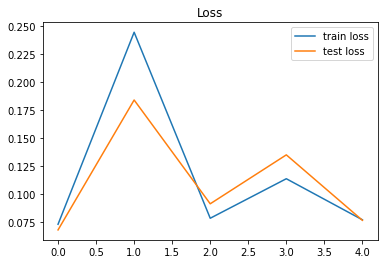

In [289]:
plt.plot(np.array(train_losses)[:,0])
plt.plot(np.array(test_losses)[:,0])
plt.legend(['train loss','test loss'])
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

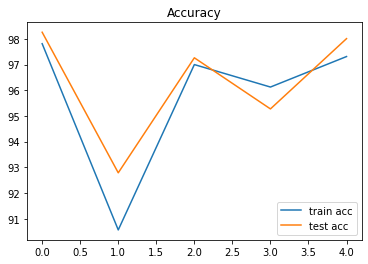

In [290]:
plt.plot(np.array(train_losses)[:,1])
plt.plot(np.array(test_losses)[:,1])
plt.legend(['train acc','test acc'])
plt.title('Accuracy')